In [33]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchsampler import ImbalancedDatasetSampler
import matplotlib.pyplot as plt
import os
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from functools import reduce
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
import pandas as pd
import sklearn 

In [34]:
import loaders as l
import models as m
import train_eval as te

In [35]:
train_dir = "C:/Users/33783/Desktop/start_deep/start_deep/Projet_ML/train_images"
test_dir = "C:/Users/33783/Desktop/start_deep/start_deep/Projet_ML/test_images"

transform = transforms.Compose(
    [transforms.Grayscale(), 
     transforms.ToTensor(), 
     transforms.Normalize(mean=(0,),std=(1,))])

valid_size = 0.2
batch_size = 32

train_loader,valid_loader,test_loader=l.make_all_loaders(train_dir,test_dir,transform,valid_size,batch_size)
classes = ('noface','face')

print(test_loader.dataset.targets.count(0))
print(test_loader.dataset.targets.count(1))


6831
797


BaseNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


C:\Users\33783\anaconda3\envs\insa-cap\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[ 1, 2000] loss: 0.160 f1_score on validation set : 0.942
[ 2, 2000] loss: 0.036 f1_score on validation set : 0.965
[ 3, 2000] loss: 0.021 f1_score on validation set : 0.974
[ 4, 2000] loss: 0.016 f1_score on validation set : 0.980
[ 5, 2000] loss: 0.013 f1_score on validation set : 0.983
[ 6, 2000] loss: 0.010 f1_score on validation set : 0.985
[ 7, 2000] loss: 0.007 f1_score on validation set : 0.987
[ 8, 2000] loss: 0.008 f1_score on validation set : 0.988
[ 9, 2000] loss: 0.006 f1_score on validation set : 0.989
[10, 2000] loss: 0.005 f1_score on validation set : 0.990
[11, 2000] loss: 0.004 f1_score on validation set : 0.991
[12, 2000] loss: 0.004 f1_score on validation set : 0.991
[13, 2000] loss: 0.004 f1_score on validation set : 0.992
[14, 2000] loss: 0.004 f1_score on validation set : 0.992
[15, 2000] loss: 0.004 f1_score on validation set : 0.993


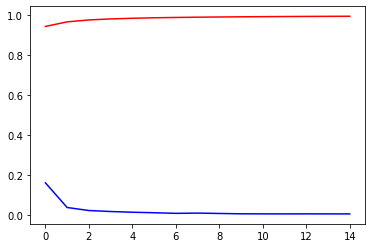

In [36]:
net = m.BaseNet()
print(net)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
#l'original mais moins bonne #optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

epochs=15

#Training

all_labels,all_predicted,all_losses,all_accuracies,all_f1scores= te.train_v1(net,criterion,optimizer,epochs,train_loader,valid_loader)
            
plt.plot(all_losses, color='blue')
plt.plot(all_f1scores, color='red')

In [37]:
saved_model_path='C:/Users/33783/Desktop/start_deep/start_deep/Projet_ML/firstModel'
#torch.save(net.state_dict(), saved_model_path )

In [38]:
net = m.BaseNet()
net.load_state_dict(torch.load(saved_model_path))

<All keys matched successfully>

In [41]:
te.calc_metrics_v1(net,test_loader,show=True) 

TypeError: calc_metrics_v1() missing 2 required positional arguments: 'all_labels' and 'all_predicted'

In [40]:
#print(all_labels)
#print()
#print()
#print('---------------------------------------------------------------')
#print(all_predicted)
#te.calc_metrics_v1(net,test_loader,all_labels,all_predicted,show=True) 


all_predicted=[]
all_labels=[]
for i, data in enumerate(test_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            outputs = net(inputs)
            y_pred_softmax = torch.log_softmax(outputs, dim = 1)
            _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)
            all_predicted.extend(np.array(y_pred_tags))
            all_labels.extend(np.array(labels))

print(pd.DataFrame(sklearn.metrics.confusion_matrix(all_labels, all_predicted,normalize='true'), columns=test_loader.dataset.targets.tolist(), index=test_loader.dataset.targets.tolist()))

AttributeError: 'list' object has no attribute 'tolist'

In [ ]:
#print(test_loader.dataset.targets)
#print(pd.DataFrame(sklearn.metrics.confusion_matrix(bow_y_test, bow_y_pred), columns=CLASS_NAMES, index=CLASS_NAMES))

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

In [ ]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(2):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))